# Imports

In [1]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [2]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print(tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

DEBUG - 2021-08-03 16:00:12,859 - retrain_ipynb - --=logging started=--


2.5.0
Running on CPU:arm


In [3]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 
analyser.hyperparams.__file__

Nemoware Analyser v2.4.5
USING WORKDIR: [/Users/artem/work/nemo/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/Users/artem/work/nemo/work/datasets]
reports_dir: [/Users/artem/work/nemo/work/reports]


/Users/artem/work/nemo/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


'/Users/artem/work/nemo/analyser/analyser/hyperparams.py'

### Prepare workdir

In [4]:
from pathlib import Path
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /Users/artem/work/nemo/work


### Imports...

In [5]:
%matplotlib inline

import pandas as pd
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9629629629629629


### Query DB for contact IDs

#### Load meta data CSV

In [6]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'])
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'])

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except Exception as ex:
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(lastdate, export_fn)
stats

2021-08-01 10:00:37.036000 /Users/artem/work/nemo/work/contract_trainset_meta.temp.csv


,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len
60b7a55b061c76d77545505a,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,7.000000e+08,2021-07-29 08:56:09.177,2021-06-04 21:39:30.461,51064791f578e6b4ba62f717a09832db,2021-07-29 14:20:27.093368,NaN,20.366591,1218.0,False,RUB,4088.0
60b7a4cc061c76d7754546b0,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,4.285374e+08,2021-07-29 09:05:58.705,2021-06-03 06:10:15.320,1775ac8122d39314d9d8c7e8c0c03437,2021-07-29 14:20:25.189336,NaN,19.875888,563.0,NaN,RUB,774.0
60b7a5b1061c76d775455517,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,1.846700e+08,NaT,2021-06-05 16:36:09.054,50f010a37f21887b6d0242450c310cdb,2021-07-29 14:40:00.388647,NaN,19.034081,75.0,NaN,RUB,1062.0
60b7a5b1061c76d77545551e,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,2.969460e+07,NaT,2021-06-05 16:41:37.040,b14d88a9f8c9c698e7119e3c722267e2,2021-07-29 14:40:00.415121,NaN,17.206476,108.0,NaN,RUB,311.0
60b7a59a061c76d775455383,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,5.000000e+05,NaT,2021-06-05 10:03:03.705,2d78ec018ce5f8e710f0399e15a0f25f,2021-07-29 14:39:13.808920,NaN,13.122365,345.0,NaN,RUB,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60b7a595061c76d775455308,NaN,2.3.14,Газпромнефть-Каталитические системы,Измерительная техника,Заказчик,Исполнитель,Service,2.540000e+05,NaT,2021-06-05 08:14:43.166,21b3cefccb16f68f46eab84875555ad9,2021-07-29 14:38:53.843724,NaN,12.445093,277.0,NaN,RUB,4970.0
60b7a599061c76d775455369,NaN,2.3.14,Бизнес для бизнеса,Газпромнефть-Каталитические системы,Исполнитель,Заказчик,Service,1.200000e+05,NaT,2021-06-05 09:41:59.288,e91883d22724485a0f74c9961350acfa,2021-07-29 14:39:09.497453,NaN,11.695255,577.0,NaN,RUB,1370.0
60b7a5b5061c76d77545557a,NaN,2.3.14,Центр предпринимательских рисков,Газпромнефть-Каталитические системы,Исполнитель,Заказчик,Service,4.100000e+04,NaT,2021-06-05 18:15:41.276,d10b504216611046cb75a7b314568fcb,2021-07-29 14:40:16.223362,NaN,10.621352,1319.0,NaN,RUB,3527.0
60ebe82ecddbb3c487368c25,NaN,2.4.4,БДО Юникон,Газпром-нефть,Исполнитель,NaN,Service,NaN,NaT,2021-07-12 09:59:02.421,9afd3f4c0c6385de2e8fcc34cae08127,2021-07-29 14:40:18.736357,NaN,NaN,NaN,NaN,NaN,6045.0


## Fetch fresh docs from Mongo DB

In [7]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType": "CONTRACT"},
      
    {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(1000)

res = list([i for i in res])

_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

DB HOST IS: 192.168.10.36


/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)


#### Всего новых документов после 2021-08-01 10:00:37.036000 : 1

[{'_id': ObjectId('60b7a55c061c76d775455070'),
  'user': {'updateDate': datetime.datetime(2021, 8, 2, 13, 33, 6, 624000)}}]

In [8]:
from datetime import datetime
from math import log1p

from pandas import DataFrame

from analyser.persistence import DbJsonDoc
from trainsets.retrain_contract_uber_model import flatten_attributes_tree


def add_stats_record(d: DbJsonDoc, stats: DataFrame):
  _id = str(d.get_id())

  attr_map = flatten_attributes_tree(d.get_attributes_tree())

  # stats.at[_id, 'valid'] = True

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  if 'version' in d.analysis['attributes_tree']:
    stats.at[_id, 'version'] = '.'.join([str(x) for x in d.analysis['attributes_tree']['version']])
  else:
    stats.at[_id, 'version'] = d.analysis['version']

  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = d.analysis['analyze_timestamp']


  _value_tag = attr_map['sign_value_currency/value']
  if _value_tag:
    stats.at[_id, 'value'] = _value_tag['value']
    stats.at[_id, 'value_log1p'] = log1p(_value_tag['value'])
    stats.at[_id, 'value_span'] = _value_tag['span'][0]
    # find_in_dict('price.amount.span.0', d.get_attributes_tree())
    
  def _map_val(src, dest):
    if attr_map[src]:
        stats.at[_id, dest] = attr_map[src]['value']
        
  _map_val('sign_value_currency/currency', 'currency')
  _map_val('org-1-alias', 'org-1-alias')
  _map_val('org-2-alias', 'org-2-alias')
  _map_val('org-1-name', 'org-1-name')
  _map_val('org-2-name', 'org-2-name')
  _map_val('subject', 'subject')
 


  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = d.user[
      'updateDate']  # find_in_dict('attributes_tree.creation_date', d.user)


In [9]:
# res[:4]
# from tqdm import tqdm

docs_ids = [i["_id"] for i in res]   
# stats = DataFrame()
    

for k, oid in enumerate(docs_ids):
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
    
    add_stats_record(jd, stats)
    
    if k % 20 == 0:
        print(k)
        stats.to_csv(export_fn, index=True)
    
stats.to_csv(export_fn, index=True)
stats

0


,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len
60b7a55b061c76d77545505a,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,7.000000e+08,2021-07-29 08:56:09.177,2021-06-04 21:39:30.461,51064791f578e6b4ba62f717a09832db,2021-07-29 14:20:27.093368,NaN,20.366591,1218.0,False,RUB,4088.0
60b7a4cc061c76d7754546b0,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,4.285374e+08,2021-07-29 09:05:58.705,2021-06-03 06:10:15.320,1775ac8122d39314d9d8c7e8c0c03437,2021-07-29 14:20:25.189336,NaN,19.875888,563.0,NaN,RUB,774.0
60b7a5b1061c76d775455517,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,1.846700e+08,NaT,2021-06-05 16:36:09.054,50f010a37f21887b6d0242450c310cdb,2021-07-29 14:40:00.388647,NaN,19.034081,75.0,NaN,RUB,1062.0
60b7a5b1061c76d77545551e,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,2.969460e+07,NaT,2021-06-05 16:41:37.040,b14d88a9f8c9c698e7119e3c722267e2,2021-07-29 14:40:00.415121,NaN,17.206476,108.0,NaN,RUB,311.0
60b7a59a061c76d775455383,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,5.000000e+05,NaT,2021-06-05 10:03:03.705,2d78ec018ce5f8e710f0399e15a0f25f,2021-07-29 14:39:13.808920,NaN,13.122365,345.0,NaN,RUB,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60b7a595061c76d775455308,NaN,2.3.14,Газпромнефть-Каталитические системы,Измерительная техника,Заказчик,Исполнитель,Service,2.540000e+05,NaT,2021-06-05 08:14:43.166,21b3cefccb16f68f46eab84875555ad9,2021-07-29 14:38:53.843724,NaN,12.445093,277.0,NaN,RUB,4970.0
60b7a599061c76d775455369,NaN,2.3.14,Бизнес для бизнеса,Газпромнефть-Каталитические системы,Исполнитель,Заказчик,Service,1.200000e+05,NaT,2021-06-05 09:41:59.288,e91883d22724485a0f74c9961350acfa,2021-07-29 14:39:09.497453,NaN,11.695255,577.0,NaN,RUB,1370.0
60b7a5b5061c76d77545557a,NaN,2.3.14,Центр предпринимательских рисков,Газпромнефть-Каталитические системы,Исполнитель,Заказчик,Service,4.100000e+04,NaT,2021-06-05 18:15:41.276,d10b504216611046cb75a7b314568fcb,2021-07-29 14:40:16.223362,NaN,10.621352,1319.0,NaN,RUB,3527.0
60ebe82ecddbb3c487368c25,NaN,2.4.4,БДО Юникон,Газпром-нефть,Исполнитель,NaN,Service,NaN,NaT,2021-07-12 09:59:02.421,9afd3f4c0c6385de2e8fcc34cae08127,2021-07-29 14:40:18.736357,NaN,NaN,NaN,NaN,NaN,6045.0


In [10]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len
60b7a55b061c76d77545505a,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,7.000000e+08,2021-07-29 08:56:09.177,2021-06-04 21:39:30.461,51064791f578e6b4ba62f717a09832db,2021-07-29 14:20:27.093368,NaN,20.366591,1218.0,False,RUB,4088.0
60b7a4cc061c76d7754546b0,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,4.285374e+08,2021-07-29 09:05:58.705,2021-06-03 06:10:15.320,1775ac8122d39314d9d8c7e8c0c03437,2021-07-29 14:20:25.189336,NaN,19.875888,563.0,NaN,RUB,774.0
60b7a5b1061c76d775455517,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,1.846700e+08,NaT,2021-06-05 16:36:09.054,50f010a37f21887b6d0242450c310cdb,2021-07-29 14:40:00.388647,NaN,19.034081,75.0,NaN,RUB,1062.0
60b7a5b1061c76d77545551e,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,2.969460e+07,NaT,2021-06-05 16:41:37.040,b14d88a9f8c9c698e7119e3c722267e2,2021-07-29 14:40:00.415121,NaN,17.206476,108.0,NaN,RUB,311.0
60b7a59a061c76d775455383,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,5.000000e+05,NaT,2021-06-05 10:03:03.705,2d78ec018ce5f8e710f0399e15a0f25f,2021-07-29 14:39:13.808920,NaN,13.122365,345.0,NaN,RUB,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60b7a595061c76d775455308,NaN,2.3.14,газпромнефть-каталитические системы,измерительная техника,заказчик,исполнитель,Service,2.540000e+05,NaT,2021-06-05 08:14:43.166,21b3cefccb16f68f46eab84875555ad9,2021-07-29 14:38:53.843724,NaN,12.445093,277.0,NaN,RUB,4970.0
60b7a599061c76d775455369,NaN,2.3.14,бизнес для бизнеса,газпромнефть-каталитические системы,исполнитель,заказчик,Service,1.200000e+05,NaT,2021-06-05 09:41:59.288,e91883d22724485a0f74c9961350acfa,2021-07-29 14:39:09.497453,NaN,11.695255,577.0,NaN,RUB,1370.0
60b7a5b5061c76d77545557a,NaN,2.3.14,центр предпринимательских рисков,газпромнефть-каталитические системы,исполнитель,заказчик,Service,4.100000e+04,NaT,2021-06-05 18:15:41.276,d10b504216611046cb75a7b314568fcb,2021-07-29 14:40:16.223362,NaN,10.621352,1319.0,NaN,RUB,3527.0
60ebe82ecddbb3c487368c25,NaN,2.4.4,бдо юникон,газпром-нефть,исполнитель,NaN,Service,NaN,NaT,2021-07-12 09:59:02.421,9afd3f4c0c6385de2e8fcc34cae08127,2021-07-29 14:40:18.736357,NaN,NaN,NaN,NaN,NaN,6045.0


In [11]:
stats2['subject'].value_counts()

Service                              1098
Deal                                  466
GeneralContract                       119
Renting                               119
Loans                                  75
AgencyContract                         65
Insurance                              47
DealIntellectualProperty               39
RealEstate                             38
Charity                                36
RealEstateTransactions                 25
PledgeEncumbrance                       6
BigDeal                                 6
ParticipationInOtherOrganizations       4
BankGuarantees                          4
Other                                   3
AssetTransactions                       1
Name: subject, dtype: int64

In [12]:
stats2['org-1-alias'].value_counts()

заказчик                   683
исполнитель                470
покупатель                 321
продавец                    89
поставщик                   84
                          ... 
управляемая организация      1
субсубарендатор              1
нск                          1
благополучатель              1
-                            1
Name: org-1-alias, Length: 72, dtype: int64

In [13]:
stats2['org-2-alias'].value_counts()

исполнитель     554
заказчик        505
поставщик       283
покупатель      172
подрядчик       130
               ... 
весна             1
компания          1
доверитель        1
инвестором        1
жертвователь      1
Name: org-2-alias, Length: 65, dtype: int64

In [14]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
stats2.head(40)

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score
5ec2b8da665f7603e03b127d,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,2.3.14,сбербанк россии,оск,кредитор,проект,Renting,1.394400e+10,2020-09-10 11:10:15.402,2020-09-10 11:10:43.308,6d075df102717d0a1291facdb16ae21e,2021-07-29 14:23:55.661347,NaN,23.358315,313.0,NaN,RUB,12174.0,False,0.295419
5ec2b8d9665f7603e03b1238,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,2.3.14,газпромнефть-региональные продажи,нептун,залогодатель,залогодержатель,PledgeEncumbrance,6.000000e+07,2020-05-21 15:27:48.922,2020-05-21 15:29:00.410,7e9e0a5f729f876a5b3055de5076db9d,2021-07-29 14:23:59.738433,NaN,17.909855,169.0,NaN,RUB,2395.0,False,0.576329
5fe34f63b770574a005553db,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe3...,2.3.13,газпромнефть-снабжение,эта,залогодатель,залогодержатель,PledgeEncumbrance,6.000000e+07,2021-07-22 09:19:27.348,2020-12-23 17:14:31.820,b42ed28b9a72f51612db24cbd7b7a4f0,2021-07-29 14:20:42.942401,NaN,17.909855,160.0,NaN,NaN,2386.0,False,0.576329
5fca2aae9083b679224c7614,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,2.3.14,газпромнефть-оренбург,ноябрьскнефтегазсвязь,"сторона 2""",сторона 1,DealIntellectualProperty,5.551000e+03,2021-07-30 10:05:52.667,2020-12-10 09:16:59.672,d72b4a8533d4f1badede50d142e6a207,2021-07-30 13:13:24.987028,NaN,8.621914,310.0,NaN,RUB,4615.0,False,1.233369
60b7a58e061c76d77545526f,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-каталитические системы,газпромбанк,приказодатель,банк,Loans,3.130200e+06,2021-07-31 15:43:37.710,2021-06-05 06:22:34.302,12a28c1f993034480f13fd437253452c,2021-07-31 18:47:45.790842,NaN,14.956608,186.0,NaN,EURO,5573.0,False,1.252050
60002adfb08473039387bcae,http://gpn-audit.nemosoft.ru/#/audit/edit/6000...,2.3.14,газпромнефть-снабжение,газпром нефть,правообладатель,приобретатель,Deal,4.400005e+07,2021-07-20 07:47:49.711,2021-01-14 14:29:31.907,772ba956e0729d7fee4509c818ae33f5,2021-07-29 14:21:13.540871,NaN,17.599701,430.0,NaN,NaN,1511.0,False,1.264505
60b7a4c3061c76d7754545e3,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-аэро брянск,газпромнефть-аэро,субсубарендатор,субарендатор,Renting,1.080000e+04,2021-07-23 12:29:19.231,2021-06-03 03:28:32.872,94f0763cb517ebf7bcf1bcb4ba009e08,2021-07-29 14:20:31.404607,NaN,9.287394,406.0,NaN,NaN,2276.0,False,1.725183
5fca2ab09083b679224c7639,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,2.3.14,газпромнефть-оренбург,газрромнефть-гео,"агент,",принципал,AgencyContract,1.548241e+07,2021-07-30 09:56:06.103,2020-12-10 09:32:43.717,76ed0c474a4541d4de06f029c54a978d,2021-07-30 13:13:25.206495,NaN,16.555215,464.0,NaN,RUB,3311.0,False,1.789872
60b7a4c3061c76d7754545da,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-аэро брянск,газпромнефть-ангара,управляемая организация,управляющая организация,Service,5.000000e+04,2021-06-22 13:40:54.455,2021-06-03 03:18:14.469,407261fdff9a7a1156a2e909c57311dd,2021-07-29 14:21:22.701427,NaN,10.819798,1240.0,NaN,NaN,2107.0,False,1.865584
5fc7a034c54bc33809e261a8,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,газпромнефть-оренбург,ноябрьскнефтегазсвязь,сторона 2,сторона 1,DealIntellectualProperty,5.551650e+03,2021-07-30 09:56:40.050,2020-12-02 14:26:35.267,a8480e06e4cb16d8a2069b11b64b68f6,2021-07-30 13:13:23.948618,NaN,8.622031,507.0,NaN,RUB,4812.0,False,1.954817


In [15]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [16]:
stats2['len'] //= 5 #similar lens
stats2['len'] *= 5 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score
5fb3b9b000881c332b56746c,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-11-17 11:55:01.865,52a9649ba88d76e1f943d31db634dff4,2021-07-29 14:27:33.322139,NaN,NaN,NaN,NaN,NaN,49345.0,True,1.440000e+08
5fc7a047c54bc33809e26372,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,газпромнефть-оренбург,ноябрьскнефтегазсвязь,заказчик,NaN,Service,90619807.0,NaT,2020-12-03 08:07:48.699,82137d4b0ded9b81b1d12f4d9e98c383,2021-07-29 14:32:11.482145,NaN,18.322183,4503.0,NaN,RUB,49340.0,True,2.993734e+03
5fca2acd9083b679224c77da,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,2.3.14,газпромнефть-оренбург,ноябрьскнефтегазсвязь,заказчик,подрядчик,GeneralContract,90619807.0,2021-07-30 21:59:37.858,2020-12-10 10:40:36.652,6b64d52e5ecb4941696164ed4950e735,2021-07-31 18:18:15.645746,NaN,18.322183,4207.0,NaN,RUB,49045.0,False,2.494719e+01
5fb3b9a800881c332b567433,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-11-17 11:54:59.086,287d93101b752b5f041d476d7196864e,2021-07-29 14:27:25.900821,NaN,NaN,NaN,NaN,NaN,44185.0,True,1.440000e+08
5fc7a044c54bc33809e2634d,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-12-02 14:13:46.114,2be147450a483219b8d7139324d23b03,2021-07-29 14:32:01.545688,NaN,NaN,NaN,NaN,NaN,44185.0,True,1.440000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60b7a5b1061c76d775455521,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,NaN,NaT,2021-06-05 16:41:48.457,b1a3985249b51612f7ac074d2966d2b6,2021-07-29 14:40:00.437010,NaN,NaN,NaN,NaN,NaN,195.0,True,7.562328e+07
60b7a4f6061c76d7754549e4,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,NaN,NaT,2021-06-03 23:10:28.433,c37abb17ae9e5c8ba15d4ffa2ada51b0,2021-07-29 14:35:11.021034,NaN,NaN,NaN,NaN,NaN,90.0,True,7.562328e+07
60b7a502061c76d775454acf,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,NaN,NaT,2021-06-04 02:16:34.669,0e4c83130e2fa3bda54cdec67dd53694,2021-07-29 14:35:31.486684,NaN,NaN,NaN,NaN,NaN,80.0,True,7.562328e+07
60b7a58e061c76d77545525d,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,NaN,NaT,2021-06-05 06:12:14.896,16919b50a8bbeca754edbb08c5636bb5,2021-07-29 14:38:30.637880,NaN,NaN,NaN,NaN,NaN,25.0,True,6.638036e+07


In [17]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])


In [18]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

2616

In [19]:
unks

 4.995280e+17    7
 6.119083e+18    7
-8.185570e+18    6
-8.256605e+18    6
 4.641526e+18    6
                ..
-2.419843e+18    1
-2.443140e+18    1
-2.451713e+18    1
-2.453739e+18    1
 9.205597e+18    1
Name: hash, Length: 2009, dtype: int64

### Drop duplicates

In [20]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
dups_s = dups_s[dups_s[score_column_name] < 5000]

# dups_s [dups_s['len'] > 30000].head(40)

## Remove rare subjects and very long docs

In [21]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=40, alpha=0.8)

In [22]:
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=5, alpha=0.8)

In [23]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len']>30000:
        print ('excluding', row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 8:
            print ('excluding', row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fbf75c75d05d73d0295fac0 GeneralContract 38360.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fca2acd9083b679224c77da GeneralContract 49045.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fca2ac79083b679224c7750 GeneralContract 41250.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fca2ac79083b679224c774f GeneralContract 39315.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fca2ac99083b679224c77b0 GeneralContract 39000.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fca2ac89083b679224c7786 GeneralContract 43935.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5f9672f182451803b5001df7 GeneralContract 31175.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/60b7a589061c76d77545523c GeneralContract 32720.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2b8da665f7603e03b126b GeneralContract 31095.0
excluding http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7a047c54bc33

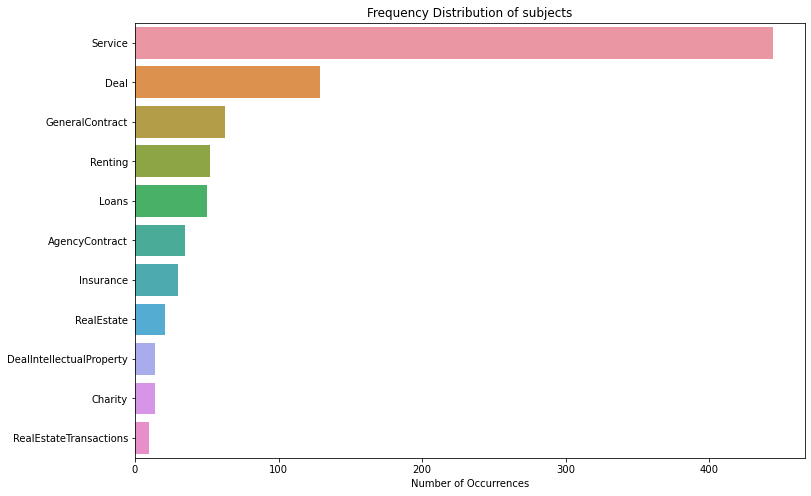

Service                     444
Deal                        129
GeneralContract              63
Renting                      52
Loans                        50
AgencyContract               35
Insurance                    30
RealEstate                   21
DealIntellectualProperty     14
Charity                      14
RealEstateTransactions       10
Name: subject, dtype: int64


In [24]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=cnt.values, y=cnt.index)

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()
print(cnt)

In [25]:
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.good.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

### 873 - Всего новых документов в обучающем наборе на 2021-08-01 10:00:37.036000

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,...,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score,hash,dups
5ec2b8da665f7603e03b127d,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,2.3.14,сбербанк россии,оск,кредитор,проект,Renting,1.394400e+10,2020-09-10 11:10:15.402,2020-09-10 11:10:43.308,...,NaN,23.358315,313.0,True,RUB,12170.0,False,0.295419,3.250495e+18,1.0
5fca2aae9083b679224c7614,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,2.3.14,газпромнефть-оренбург,ноябрьскнефтегазсвязь,"сторона 2""",сторона 1,DealIntellectualProperty,5.551000e+03,2021-07-30 10:05:52.667,2020-12-10 09:16:59.672,...,NaN,8.621914,310.0,True,RUB,4615.0,False,1.233369,7.380915e+17,1.0
60b7a58e061c76d77545526f,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-каталитические системы,газпромбанк,приказодатель,банк,Loans,3.130200e+06,2021-07-31 15:43:37.710,2021-06-05 06:22:34.302,...,NaN,14.956608,186.0,True,EURO,5570.0,False,1.252050,-6.417778e+18,1.0
60002adfb08473039387bcae,http://gpn-audit.nemosoft.ru/#/audit/edit/6000...,2.3.14,газпромнефть-снабжение,газпром нефть,правообладатель,приобретатель,Deal,4.400005e+07,2021-07-20 07:47:49.711,2021-01-14 14:29:31.907,...,NaN,17.599701,430.0,True,NaN,1510.0,False,1.264505,-4.427297e+17,2.0
60b7a4c3061c76d7754545e3,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-аэро брянск,газпромнефть-аэро,субсубарендатор,субарендатор,Renting,1.080000e+04,2021-07-23 12:29:19.231,2021-06-03 03:28:32.872,...,NaN,9.287394,406.0,True,NaN,2275.0,False,1.725183,-4.414758e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fdb2140542ce403c92b454c,http://gpn-audit.nemosoft.ru/#/audit/edit/5fdb...,2.3.14,рекламно-информационное агентство «город»,магна,спонсируемый,спонсор,Deal,NaN,2020-12-18 09:26:17.634,2020-12-18 12:26:25.483,...,NaN,NaN,NaN,True,NaN,2470.0,False,4664.415368,-4.423079e+18,1.0
5fdb2141542ce403c92b456c,http://gpn-audit.nemosoft.ru/#/audit/edit/5fdb...,2.3.14,рекламно-информационное агентство «город»,шевцова анна викторовна,спонсируемый,спонсор,Deal,NaN,2020-12-18 09:27:20.264,2020-12-18 12:27:26.400,...,NaN,NaN,NaN,True,NaN,2380.0,False,4664.415368,2.079470e+18,1.0
5fc7a034c54bc33809e261ce,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,газпромнефть-оренбург,газпромнефть-снабжение,принципал,агент,AgencyContract,NaN,2020-12-19 14:27:41.953,2020-12-19 17:28:11.494,...,NaN,NaN,NaN,True,NaN,2255.0,False,4793.712945,2.651853e+18,1.0
5fca2aad9083b679224c7606,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,2.3.14,газпромнефть-оренбург,газпромнефть-снабжение,принципал,агент,AgencyContract,NaN,2020-12-09 15:05:30.896,2020-12-09 15:05:39.397,...,NaN,NaN,NaN,True,NaN,2010.0,False,4793.712945,-1.421830e+18,1.0


In [26]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [27]:
dups_s[dups_s['unseen']]

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,...,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score,hash,dups
60b7a4c2061c76d7754545ba,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-снабжение,газпромнефть-каталитические системы,поверенный,доверитель,Service,1.000000e+04,NaT,2021-06-03 03:00:53.937,...,NaN,9.210440,1361.0,True,RUB,1995.0,True,34.735420,-8.260241e+18,1.0
5fca2aab9083b679224c75e1,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,2.3.14,газпромнефть-оренбург,газпром нефть (пао газпром нефть,заемщик»,займодавец,Loans,1.000000e+09,NaT,2020-12-04 12:38:38.017,...,NaN,20.723266,182.0,True,RUB,1345.0,True,50.466415,-7.871414e+17,1.0
60b7a4c1061c76d775454594,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,мобильные телесистемы,газпромнефть-каталитические системы,мтс,абонент,Service,5.601250e+04,NaT,2021-06-03 02:26:09.061,...,NaN,10.933348,2742.0,True,RUB,13430.0,True,51.829629,-7.576761e+18,1.0
5fb399dd39d5e82e9081847d,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,газпромнефть-заполярье,газпром добыча оренбург,субарендатор,субарендодатель,Deal,1.859225e+05,NaT,2020-11-17 10:06:27.310,...,NaN,12.133091,472.0,True,RUB,3295.0,True,53.742060,-7.950399e+18,1.0
60b7a4f4061c76d7754549bd,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,страховое общество газовой промышленности,газпромнефть-каталитические системы,страховщик,страхователь,Insurance,2.809844e+10,NaT,2021-06-03 22:30:38.761,...,NaN,24.058980,1247.0,True,RUB,13690.0,True,55.238964,4.404312e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb3d4a078df3635f5441c2e,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,рекламно-информационное агентство «город»,NaN,исполнитель,заказчик,Service,8.350000e+04,NaT,2020-11-17 14:34:48.435,...,NaN,11.332614,323.0,True,RUB,4360.0,True,4262.248696,5.901418e+18,1.0
5fb3d4a078df3635f5441c63,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,рекламно-информационное агентство «город»,NaN,исполнитель,заказчик,Service,8.350000e+04,NaT,2020-11-17 14:56:24.561,...,NaN,11.332614,362.0,True,RUB,4425.0,True,4262.248696,8.312334e+18,1.0
5fb3b97f00881c332b5672d6,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,газпромнефть-оренбург,южуралнефтегаз,NaN,NaN,DealIntellectualProperty,8.117109e+08,NaT,2020-11-17 12:17:28.919,...,NaN,20.514655,1299.0,True,RUB,4275.0,True,4315.603042,8.448072e+18,1.0
5fb6750c33c72547b7550151,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,2.3.14,арктика медиа,NaN,исполнитель,заказчик,Service,5.833333e+04,NaT,2020-11-19 14:40:49.697,...,NaN,10.973946,363.0,True,RUB,4195.0,True,4401.554240,8.518449e+18,2.0
